<a href="https://colab.research.google.com/github/akansh12/learn-satellite-imagery-DL/blob/main/notebooks/Learn_1__EarthSurfaceWater_withTorchGeo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Contents

The idea is to cover the following topics throughout the series:

    The dataset;
    Creating RasterDatasets, DataLoaders and Samplers for images and masks;
    Intersection Dataset;
    Normalizing the data;
    Creating spectral indices;
    Creating the segmentation model (U-Net);
    Loss function and metrics; and
    Training loop.

In [2]:
%pip install rasterio -q
%pip install torchgeo -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.5/292.5 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.4/653.4 kB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import logging
# this line is to avoid warnings from Rasterio to be printed on screen
# the warning is explained here: https://stackoverflow.com/questions/74089170/suppress-rasterio-warning-warning-1-tiffreaddirectory
logger = logging.getLogger("rasterio")
logger.setLevel(logging.ERROR)

In [3]:
import rasterio as rio
import torchgeo

#Dataset:Earth Surface Water Dataset

The dataset we will use is the Earth Surface Water dataset (licensed under Creative Commons Attribution 4.0 International Public License), which has patches from different parts of the world (Figure 1) and its corresponding water masks. The dataset uses optical imagery from Sentinel-2 satellite with 10m of spatial resolution.

In [ ]:
!wget https://zenodo.org/record/5205674/files/dset-s2.zip
!unzip dset-s2.zip


Opening one sample


In [6]:
from pathlib import  Path
import xarray as xr
import matplotlib.pyplot as plt

root = Path('dset-s2')
assert root.exists()

train_imgs = list((root/'tra_scene').glob('*.tif'))
train_masks = list((root/'tra_truth').glob('*.tif'))

# As the images and corresponding masks are matched by name, we will sort both lists to keep them synchronized.
train_imgs.sort(); train_masks.sort()

In [8]:
idx = 0
img = xr.open_rasterio(train_imgs[idx])
mask = xr.open_rasterio(train_masks[idx])

<ipython-input-8-6358c7839932>:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  img = xr.open_rasterio(train_imgs[idx])
<ipython-input-8-6358c7839932>:3: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  mask = xr.open_rasterio(train_masks[idx])


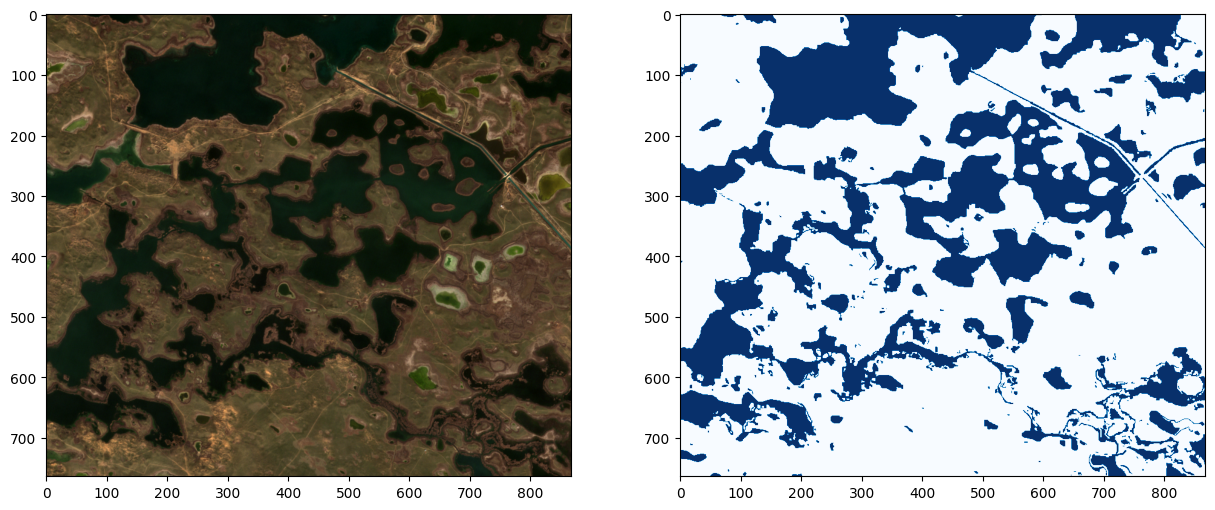

In [9]:
_, axs = plt.subplots(1, 2, figsize=(15, 6))

# plot the tile
rgb = img.data[[2, 1, 0]].transpose((1, 2, 0))/3000
axs[0].imshow(rgb.clip(min=0, max=1))

# plot the mask
axs[1].imshow(mask.data.squeeze(), cmap='Blues')
     


In [17]:
img.data[0,:,:]

(764, 868)

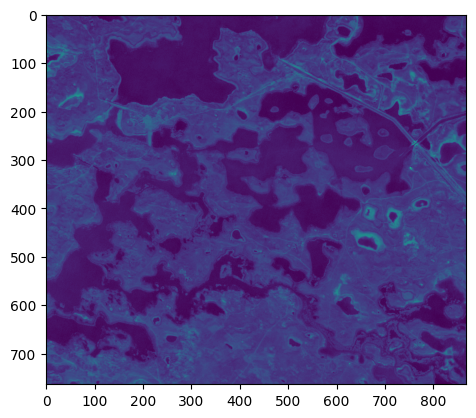

In [15]:
plt.imshow(img.data[0,:,:])

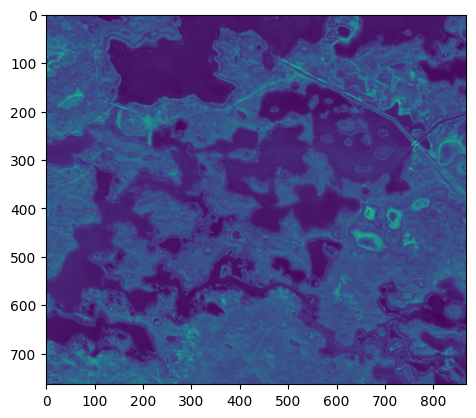

In [16]:
plt.imshow(img.data[1,:,:])

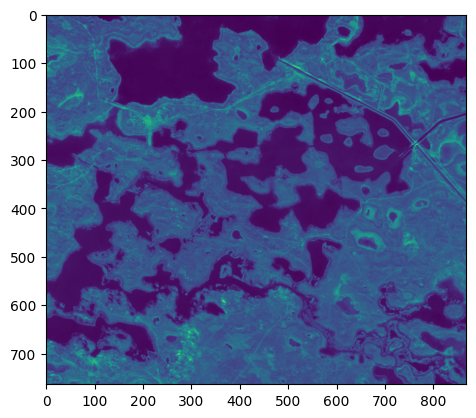

In [18]:
plt.imshow(img.data[2,:,:])

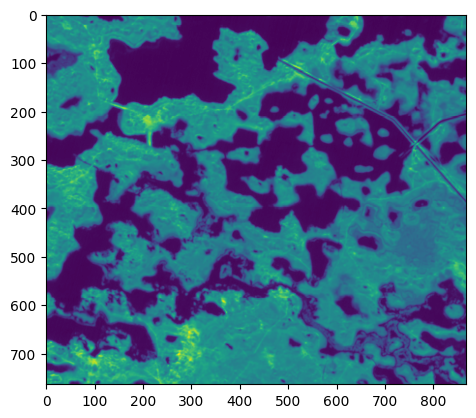

In [19]:
plt.imshow(img.data[5,:,:])

In [12]:
img.data[[2, 1, 0]]

array([[[ 707,  771,  782, ..., 1408, 1164, 1112],
        [ 687,  651,  721, ..., 1282, 1174, 1120],
        [ 957,  813,  758, ..., 1166, 1120, 1130],
        ...,
        [1946, 1892, 1688, ...,  965,  965,  963],
        [1704, 1198, 1230, ..., 1034, 1028, 1021],
        [1660, 1072, 1074, ..., 1086, 1102, 1144]],

       [[ 541,  622,  636, ..., 1098,  980,  905],
        [ 555,  535,  602, ..., 1032,  998,  969],
        [ 730,  618,  610, ...,  968,  962, 1023],
        ...,
        [1442, 1394, 1300, ...,  681,  655,  653],
        [1278,  883,  940, ...,  750,  674,  702],
        [1314,  841,  843, ...,  786,  786,  877]],

       [[ 270,  404,  376, ...,  720,  558,  525],
        [ 334,  302,  346, ...,  641,  549,  516],
        [ 446,  351,  347, ...,  562,  486,  570],
        ...,
        [ 880,  847,  816, ...,  445,  445,  469],
        [ 779,  537,  571, ...,  481,  503,  469],
        [ 778,  536,  537, ...,  544,  569,  598]]], dtype=uint16)